In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.datasets.classification import make_classification as make_classification_cu
from cuml.model_selection import train_test_split as train_test_split_cu
import cudf
from cuml.metrics import accuracy_score as accuracy_score_cu

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

cuML - это по сути sklearn, но только на GPU, хотя и не все алгоритмы в нем реализованы, как и в остальных библиотеках экосистемы rapids.

Простой пример: сгенерируем датасет для бинарной классификации, разделим стандартно на обучающее и тестовое множесто, обучим RandomForest. 

P.S. тут не про подбор параметров и наилучший способ обучения моделей =)

In [2]:
# параметры 
n_samples = 1000000
n_features = 20
n_classes = 2

# random forest depth and size
n_estimators = 30
max_depth = 15

In [3]:
%%time 
X, y = make_classification(n_classes=n_classes, n_features=n_features, n_samples=n_samples, random_state=0, class_sep=0.7)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

CPU times: user 1.78 s, sys: 0 ns, total: 1.78 s
Wall time: 1.78 s


In [9]:
%%time 
X_cu, y_cu = make_classification_cu(n_classes=n_classes, n_features=n_features, n_samples=n_samples, random_state=0, class_sep=0.7)
X_train_cu, X_test_cu, y_train_cu, y_test_cu = train_test_split_cu(X_cu, y_cu, random_state=0)

CPU times: user 60.6 ms, sys: 0 ns, total: 60.6 ms
Wall time: 59 ms


In [10]:
X_cu.device

<CUDA Device 0>

Прирост есть, да и данные сразу на GPU.

А что с обучением моделей? (даже при первом запуске все хорошо, но при повтороном еще лучше, надо "прогревать")

In [11]:
%time clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0).fit(X_train, y_train)

CPU times: user 2min 41s, sys: 0 ns, total: 2min 41s
Wall time: 2min 42s


In [12]:
%time clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0, n_jobs=-1).fit(X_train, y_train)

CPU times: user 3min 27s, sys: 0 ns, total: 3min 27s
Wall time: 29.8 s


In [13]:
%time print(f'Train: {accuracy_score(y_train, clf.predict(X_train)):.2f}, Test: {accuracy_score(y_test, clf.predict(X_test)):.2f}')

Train: 0.88, Test: 0.87
CPU times: user 5.4 s, sys: 0 ns, total: 5.4 s
Wall time: 954 ms


In [16]:
%time clf_cu = cuRFC(n_estimators=n_estimators, max_depth=max_depth, random_state=0).fit(X_train_cu, y_train_cu)

CPU times: user 818 ms, sys: 1.39 s, total: 2.2 s
Wall time: 792 ms


In [20]:
%time print(f'''Train: {accuracy_score_cu(y_train_cu, clf_cu.predict(X_train_cu)):.2f},\
                Test: {accuracy_score_cu(y_test_cu, clf_cu.predict(X_test_cu)):.2f}''')

Train: 0.99,                 Test: 0.99
CPU times: user 5.58 s, sys: 26.4 ms, total: 5.61 s
Wall time: 843 ms


Как мы видим, обучение проходит хорошо и довольно быстро, намного быстрее, чем на CPU, даже при большом количестве ядер (не говоря уже об одном)

Давайте еще посмотрим, что были у нас за данные=)

In [17]:
from cuml.manifold.umap import UMAP as cuUMAP
import umap

2023-04-27 13:48:52.663292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [20]:
%%time
umap_cpu = umap.UMAP(n_neighbors=30, n_components=2).fit(X)
umap_cpu_embeddings = umap_cpu.transform(X)

CPU times: user 6h 30min 19s, sys: 9min 56s, total: 6h 40min 16s
Wall time: 1h 17min 38s


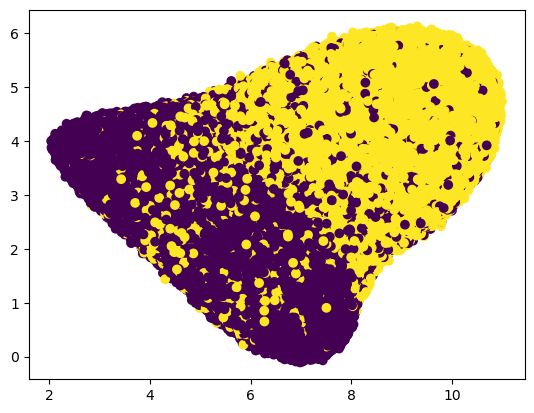

In [21]:
a, b = zip(*umap_cpu_embeddings.tolist())
plt.scatter(a, b, c=y)

In [18]:
%%time
umap_gpu = cuUMAP(n_neighbors=30, n_components=2).fit(X)
umap_gpu_embeddings = umap_gpu.transform(X)

CPU times: user 7.91 s, sys: 10.8 s, total: 18.7 s
Wall time: 18.6 s


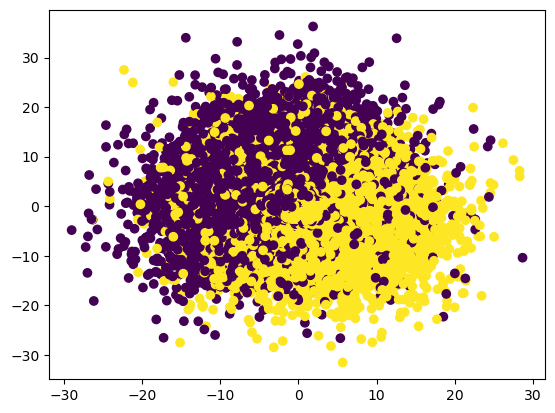

In [19]:
a, b = zip(*umap_gpu_embeddings.tolist())
plt.scatter(a, b, c=y)

### Сохранение и загурзка объектов (обучение на одном GPU)

In [20]:
from joblib import dump, load

dump(clf_cu, 'RF.model')
model = load('RF.model')
model

RandomForestClassifier()

Тажкже можно через pickle

In [21]:
import pickle

pickle.dump(clf_cu, open("RF.pkl", "wb"))
model = pickle.load(open("RF.pkl", "rb"))
model

RandomForestClassifier()

### Так, а что с multi-gpu?

In [21]:
from cuml.dask.ensemble import RandomForestClassifier as daskRFC
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from cuml.dask.common import utils as dask_utils
import dask_cudf

In [22]:
cluster = LocalCUDACluster(local_directory='/home/datalab/nfs/GPU/TEMP', CUDA_VISIBLE_DEVICES='0,1')
client = Client(cluster)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [23]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38320,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://29.64.8.138:36448,Total threads: 1
Dashboard: http://29.64.8.138:42096/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34917,


In [24]:
workers = client.has_what().keys()
n_workers = len(workers)

In [25]:
workers

dict_keys(['tcp://29.64.8.138:34483', 'tcp://29.64.8.138:36448'])

In [26]:
X_cu, y_cu = make_classification_cu(n_classes=n_classes, n_features=n_features, n_samples=n_samples, random_state=0, class_sep=0.7)

In [27]:
# Сначала нужно конвертировать данные в cudf, типы float32 и int32, на 64 будет ругаться=)
X_train_cudf = cudf.DataFrame(X_cu)
y_train_cu = y_cu.astype('int32')
y_train_cudf = cudf.Series(y_train_cu)

# Разбиваем данные на партиции (обычно сколько гпу, столькои  партиций)
X_train_dask = dask_cudf.from_cudf(X_train_cudf, npartitions=n_workers).persist()
y_train_dask = dask_cudf.from_cudf(y_train_cudf, npartitions=n_workers).persist()

In [29]:
%%time
rf = daskRFC(n_estimators=n_estimators, max_depth=max_depth, random_state=0,
                   ignore_empty_partitions=True, client=client).fit(X_train_dask, y_train_dask)

CPU times: user 124 ms, sys: 24.9 ms, total: 149 ms
Wall time: 1.16 s


Сразу после обучения распределенной модели может не получится ее сохранить, метод get_combined_model вернет путой объект. Если так происходит, то можно 1 раз вызвать метод predict, тогда модель уже будет сериализованным объектом и нормально сохранится

In [30]:
rf.predict(X_train_dask)

<dask_cudf.Series | 7 tasks | 2 npartitions>

In [32]:
import pickle

single_gpu_model = rf.get_combined_model()
pickle.dump(single_gpu_model, open("single_gpu_model.pkl", "wb"))
model = pickle.load(open("single_gpu_model.pkl", "rb"))
model

RandomForestClassifier()